## 🚀 Quick Start

This notebook presents a **minimal working example** showing how to run a cable layout optimization using `OptiWindNet` by just a few lines of code with the high-level API.
It is ideal for **first-time users** looking for **immediate results** with **minimal setup**.

The example demonstrates how to use two main components from `high-level-user-interface` of `OptiWindNet`, i.e. `WindFarmNetWork` and `Router`. There are various routers included in the `OptiWindNet` package:

* **EWRouter**

  * *Fastest option* — completes in **sub-seconds**
  * Great for quick layout generation

* **HGSRouter**

  * *Still fast* — typically completes in **1–2 seconds**
  * Produces **radial-only** solutions (no loops)
  * Useful for larger layouts or quick exploration

* **MILPRouter**

  * Delivers solutions with **quality guarantees**
  * May take a **few minutes** depending on the problem size
  * Ideal for precise and cost-optimal network designs


>Note: This notebook demonstrates how to use the `OptiWindNet` via its **API** (recommended for most users).
>
>For more explanation about different ways of wokring with `OptiWindNet`: [Jump to Example Notebooks Overview](#example-notebooks-overview)

### 🔧 Steps to Perform Cable Optimization Using `OptiWindNet`'s API

1. **Create and initialize a `WindFarmNetwork` instance**
   
   To initialize the network object, the following data is required:

   * **Required:**

     * Turbine and substation coordinates
       *(See [data_input.ipynb](api_01-data_input.ipynb) for various input formats.)*
     * Cable data (e.g., capacities and costs or at least maximum cable capacity as single number)

   * **Optional:**

     * **Borders and obstacles**: if not provided, the optimization runs without spatial constraints.
     * **Router**: the optimization solver to be used.
       If not specified, the default router (`Heuristic` with Esau-Williams algorithm) is used.
       You can also set or override the router at the time of optimization via `WindFarmNetwork_instance.optimize(router=...)`.
     * **`buff_dist`**: a buffer distance applied to borders and obstacles to slightly expand or shrink them.
       This helps when turbines are close to the edge or when integrating with external tools like **TopFarm**.

2. **Define a router**
   
   You can either provide the router when initializing the `WindFarmNetwork` or directly when calling `.optimize()`.

   `OptiWindNet` supports three classes of routers:

   * **EWRouter**: fast and practical
   * **HGSRouter**: fast and suitable for larger problems; produces radial-only networks
   * **MILPRouter**: slower but offers high-quality, optimal or near-optimal solutions with quality guarantees

3. **Run the optimization**
  
   Call:

   ```python
   WindFarmNetwork_instance.optimize(router=desired_router)
   ```

4. **Access results**
   Use `WindFarmNetwork` methods to retrieve outputs such as:

   * Total network **length** and **cost**
   * **Plots** of the layout, links, and routes
   * Detailed edge and cable information

#### **Create and initialize a `WindFarmNetwork` instance**

Import WindFarmNetwork class from `OptiWindNet API`:

In [1]:
from optiwindnet.api import WindFarmNetwork

In [2]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

Load location data

The `load_repository()` functionality of `OptiWindNet` is used to load a prebuilt *Networkx.Graph*. For more details on this functionality look into the notebook about [Load repositories containing location data](api_02-load-repositories.ipynb).

In [3]:
from optiwindnet.api import load_repository
locations = load_repository()
L = locations.doggerA

Initialzie a `WindFarmNetwork` instance with a prebuilt `L` and maximum cable capacity *(See [data\_input.ipynb](api_01-data_input.ipynb) for various input formats.)*

In [4]:
wfn = WindFarmNetwork(L=L, cables=8)

We can plot the location to make sure `wfn` is created with the correct location data.

<Axes: >

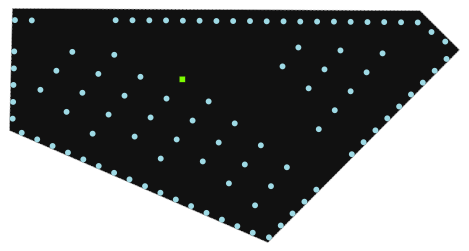

In [5]:
wfn.plot_location()

### EWRouter

To use this router, simply create an instance of the `EWRouter` class.

All arguments are **optional**, making it quick and easy to get started with minimal configuration.


In [6]:
from optiwindnet.api import EWRouter

In [7]:
ew_router = EWRouter()

In [8]:
%%timeit
res_ew = wfn.optimize(router=ew_router)

54.9 ms ± 9.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
wfn.length()

264936.30102115136

<Axes: >

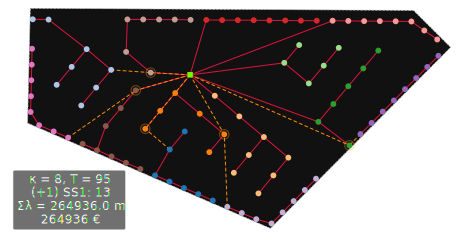

In [10]:
wfn.plot()

### HGSRouter (fast - radial only solutions - typically completes in 1–2 seconds)

To use this router, create an instance of the `HGSRouter` class.

The **only required argument** is `time_limit`, which defines how long the optimization is allowed to run (in seconds).

This approach produces **radial-only** network layouts and is useful for fast approximations, especially on medium to large wind farms.

In [11]:
from optiwindnet.api import HGSRouter

In [12]:
hgs_router = HGSRouter(time_limit=1)

> **Note:** When calling `.optimize()` multiple times on the **same** `WindFarmNetwork` instance, the previously stored solution and related information (e.g., network graph, cost, length) will be **overwritten**.
> You can verify this by checking the updated total length or by re-plotting the optimized network and comparing it to the earlier result.

In [13]:
res_hgs = wfn.optimize(router=hgs_router)

In [14]:
wfn.router

In [15]:
wfn.length()

243462.94169279

#### Plot the optimized network

>**Note:** the optimized network has a **radial layout**, forming a single connected tree without any subtree.

<Axes: >

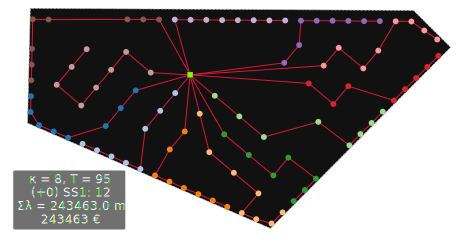

In [16]:
wfn.plot()

### MILP (high-quality solutions with guarantees – may take a few minutes)

To use this router, create an instance of the `MILP` class.
You must provide:

* `solver_name`: the MILP solver to use (e.g., `'ortools'`, `'gurobi'`, `'cbc'`)
* `time_limit`: maximum time allowed for solving (in seconds)
* `mip_gap`: acceptable optimality gap (e.g., `0.005` = 0.5%)

#### Optional arguments:

* `verbose` *(default: False)*: set to `True` to display solver progress and detailed logs
* `solver_options`: dictionary of solver-specific parameters
* `model_options`: advanced model settings (e.g., branching rules, preprocessing behavior)


In [17]:
from optiwindnet.api import MILPRouter

In [18]:
milp_router = MILPRouter(solver_name='ortools', time_limit=20, mip_gap=0.005, verbose=True)

If you run the optimization on the **same `WindFarmNetwork` instance** using a MILP solver, it will automatically use the **previous solution as a warm start** (if available).
To run MILP **without warm-starting**, create a **new instance** of the `WindFarmNetwork` object and run the MILP optimization directly—**without any prior runs using other solvers**.

> **Note:** When using a MILP solver, the solution from the previously run **Metaheuristic** router will be used as a **warm start**, since it was the last executed and its result is stored in the current `WindFarmNetwork` instance.
> An informative message will be printed about warmstating if `verbose=Ture`. You can also observe this in the log messages of the MILP router,  where the MILP solver starts with an **initial bound** equal to the total length of the network optimized by the Metaheuristic solver.


In [19]:
res_milp = wfn.optimize(router=milp_router)

>>> Using warm start: the model is initialized with the provided solution S <<<

Starting CP-SAT solver v9.14.6206
Parameters: max_time_in_seconds: 20 log_search_progress: true relative_gap_limit: 0.005
Setting number of workers to 8

Initial optimization model '': (model_fingerprint: 0xae04e94980c2e7b1)
#Variables: 1'690 (#bools: 845 in floating point objective) (1'500 primary variables)
  - 845 Booleans in [0,1]
  - 750 in [0,7]
  - 95 in [0,8]
#kAtMostOne: 635 (#literals: 1'926)
#kLinear1: 1'690 (#enforced: 1'690)
#kLinear3: 4
#kLinearN: 284 (#terms: 4'213)

Starting presolve at 0.01s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 845 terms with magnitude in [1409.66, 22631.9] average = 4594.28
[Scaling] Objective coefficient relative error: 1.60816e-10
[Scaling] Objective worst-case absolute error: 5.3597e-05
[Scaling] Objective scaling factor: 2.09715e+06
  8.77e-04s  0.00e+00d  [DetectDominanceRelations] 
  2.44e-02s  0.00e+00d  [operations_

In [20]:
wfn.router

In [21]:
wfn.length()

242929.42316730256

<Axes: >

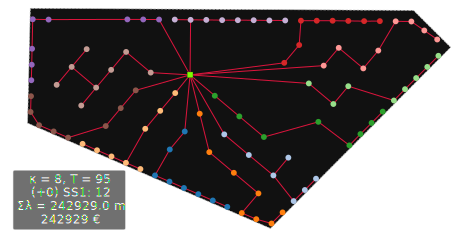

In [22]:
wfn.plot()

## Example Notebooks Overview

This repository includes a set of example notebooks to demonstrate how to use `OptiWindNet` for wind farm cable layout optimization. There are **two categories** of notebooks:

#### 📦 API-Based Examples (Recommended for Most Users)

These notebooks demonstrate how to use the **`OptiWindNet` high-level API** via its main class `WindFarmNetwork`. This approach is:

* **Simple** to use
* **Suitable for integration** with tools like **TopFarm**
* Focused on productivity and ease of interaction

Users only need to provide input data and call a few intuitive methods to perform routing and access results.

The notebooks demonstrating the **high-level API usage** of `OptiWindNet` have filenames starting with `a`, `b`, or `c`.

> ✅ Use these if you want fast prototyping or plan to integrate `OptiWindNet` into a larger workflow.


#### 🛠️ Low-Level Usage Examples

These notebooks show how to use `OptiWindNet` by **directly importing its internal modules and functions**. This approach:

* Exposes more customization and internal logic
* Requires calling several intermediate steps (e.g., preprocessing, initial tree generation, optimization, result processing)
* Is useful for **advanced users**, researchers, or developers who want fine control or want to extend the code


The notebooks demonstrating **low-level usage** of `OptiWindNet` are those with filenames starting with `0_`, `1_`, or `2_`.

> 🔍 Use these if you're exploring the algorithm, debugging, or building on top of the library internals.

